In [1]:
import GPy
import pydot
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import norm

%matplotlib inline

In [2]:
class GPR(object):
    
    added_noise=False
    
    def __init__(self,X,Y,m,k):        
        self.X=X
        self.Y=Y
        self.m=m
        self.k=k
        self.gpr=GPy.models.GPRegression(X,Y,k,mean_function=m)
        if type(self).added_noise==False:
            self.gpr.Gaussian_noise.fix(0)
                
    def optimize(self):
        self.gpr.optimize()
        self.log_likelihood=self.gpr.log_likelihood()
        self.bic=(2*self.log_likelihood)-(len(self.gpr._param_array_)*np.log(len(self.X)))
        
    def predictive_likelihood(self,x_,y_):
        mean,var=self.gpr.predict(np.array([x_]))
        return norm(mean,var).pdf(y_)
    
    def plot(self):
        return self.gpr.plot()
        
    def op(self,other,f):
        m=GPy.core.Mapping(1,1)
        m.f=lambda x:f(self.m.f(x),other.m.f(x))
        m.update_gradients=lambda a,b:None
        m.gradients_X=lambda a,b:None
        k=f(self.k,other.k)
        return GPR(self.X,self.Y,m,k)
        
    def add(self,other):
        return self.op(other,np.add)
    
    def __add__(self,other):
        return self.add(other)
    
    def mul(self,other):
        return self.op(other,np.multiply)
    
    def __mul__(self,other):
        return self.mul(other)
    
class WhiteNoise(GPR):
    
    def __init__(self,X,Y):
        m=GPy.core.Mapping(1,1)
        m.f=lambda x:0
        m.update_gradients = lambda a,b: None
        m.gradients_X = lambda a,b: None
        k=GPy.kern.White(input_dim=1)
        GPR.__init__(self,X,Y,m,k)
        
class Smooth(GPR):
    
    def __init__(self,X,Y):
        m=GPy.core.Mapping(1,1)
        m.f=lambda x:0
        m.update_gradients = lambda a,b: None
        m.gradients_X = lambda a,b: None
        k=GPy.kern.RBF(input_dim=1)
        GPR.__init__(self,X,Y,m,k)
        
class PositiveLinear(GPR):
    
    def __init__(self,X,Y):
        m=GPy.core.Mapping(1,1)
        m.f=lambda x:x
        m.update_gradients = lambda a,b: None
        m.gradients_X = lambda a,b: None
        k=GPy.kern.Linear(input_dim=1)
        GPR.__init__(self,X,Y,m,k)
        
class NegativeLinear(GPR):
    
    def __init__(self,X,Y):
        m=GPy.core.Mapping(1,1)
        m.f=lambda x:1-x
        m.update_gradients = lambda a,b: None
        m.gradients_X = lambda a,b: None
        k=GPy.kern.Linear(input_dim=1)
        GPR.__init__(self,X,Y,m,k)

In [3]:
class Grammar():
    
    def __init__(self,bases,productions):
        self.bases=bases
        self.productions=productions
        
    def expand(self,name):
        for n, sym in enumerate(name):
            if sym in self.productions:
                for rhs in self.productions[sym]:
                    new = name[:n] + rhs + name[n+1:]
                    yield new
                    
    def name_to_GPR(self,name,X,Y):
        if len(name)==1:
            return self.bases[name](X,Y)
        for sym in name:
            if sym not in ['+','*','(',')'] and self.bases[sym](X,Y)==None:
                return None
        
        queue=[]
        while len(name)>0:
            up_to_end=name[name.find("(")+1:name.find(")")]
            if '(' in up_to_end:
                inner=up_to_end.split('(')[-1]
            else:
                inner=up_to_end
            remaining=''.join(name.split('('+inner+')'))
            name=remaining

            if len(inner)==3:
                if inner[1]=='+':
                    queue.append(self.bases[inner[0]](X,Y)+self.bases[inner[2]](X,Y))
                elif inner[1]=='*':
                    queue.append(self.bases[inner[0]](X,Y)*self.bases[inner[2]](X,Y))

            elif len(inner)==2:
                if inner[0]=='+':
                    queue.append(queue[-1]+self.bases[inner[1]](X,Y))
                elif inner[0]=='*':
                    queue.append(queue[-1]*self.bases[inner[1]](X,Y))
                elif inner[1]=='+':
                    queue.append(self.bases[inner[0]](X,Y)+queue[-1])
                elif inner[1]=='*':
                    queue.append(self.bases[inner[0]](X,Y)*queue[-1])
                    
            elif len(inner)==1:
                if inner[0]=='+':
                    queue.append(queue[-2]+queue[-1])
                elif inner[0]=='*':
                    queue.append(queue[-2]+queue[-1])
        return queue[-1]

In [4]:
class GrammarSearch:
    
    def __init__(self,start,grammar):
        self.start=start
        self.grammar=grammar
                
        self.graph=pydot.Dot(graph_type='graph')
        start_node=pydot.Node('\n{0}'.format(start))
        self.graph.add_node(start_node)
    
    def display(self):
        return self.graph.create_png(prog='dot')
        
    def search(self,X,Y):
        state=self.start
        last_state=self.start
        children=[]
        state_gp=self.grammar.name_to_GPR(self.start,X,Y)
        cont=True
        while cont==True:
            cont=False
            if state_gp==None:
                state_bic=None
            else:
                state_bic=state_gp.bic
            
            for child in children:
                pnode='\n'.join(parent)
                cnode='\n'.join(child)
                edge=pydot.Edge(pnode,cnode)
                self.graph.add_edge(edge)
            if len(children)>0:
                parent=max(children)
            else:
                parent=['',state]
            children=[]
                
            for proposal in self.grammar.expand(state):
                proposal_gp=self.grammar.name_to_GPR(proposal,X,Y)
                proposal_gp.optimize()
                
                if len(children)<3 or proposal_gp.bic>min(children):
                    children.append([str(np.round(proposal_gp.bic,3)),proposal])
                if proposal_gp.bic>state_bic:
                    state=proposal
                    state_gp=proposal_gp
                    state_bic=state_gp.bic
                    cont=True
        self.state=state
        self.gpr=state_gp
                    
                

 c:\python27\lib\site-packages\paramz\transformations.py:109: RuntimeWarning:divide by zero encountered in log


p

Name : GP regression
Objective : -79.7376459532
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  linear.variances         |  5.92066425543e-10  |      +ve      |        
  Gaussian_noise.variance  |    0.0024117870531  |      +ve      |        


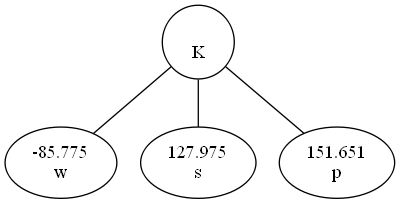

 c:\python27\lib\site-packages\matplotlib\figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


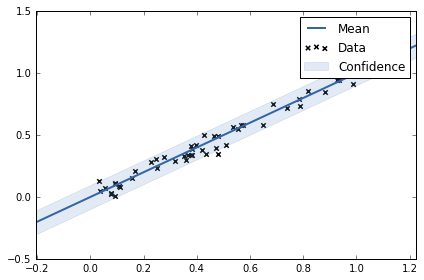

In [5]:
Smooth.added_noise=True
PositiveLinear.added_noise=True
NegativeLinear.added_noise=True


bases={'w':WhiteNoise,'s':Smooth, 'p':PositiveLinear,'n':NegativeLinear,'K':lambda x,y:None}
base_kernels=['w','s','p','n']
productions={base:['({0}{1}{2})'.format(base,op,sym) for op in ('+','*') for sym in base_kernels] for base in base_kernels}
productions['K']=base_kernels

grammar=Grammar(bases,productions)
search=GrammarSearch('K',grammar)

X = np.random.uniform(0.,1.,(50,1))
Y = X+np.random.randn(50,1)*.05

search.search(X,Y)
print search.state
print search.gpr.gpr
search.gpr.plot()
Image(search.display())

In [6]:
class Mixture:
    
    def __init__(self,X,Y,start,grammar):
        self.X=X
        self.Y=Y
        self.start=start
        self.grammar=grammar
        
        self.assignments=[0 for i in xrange(len(self.X))]
        self.experts=[(GrammarSearch(self.start,self.grammar),0)]
        self.nexperts=0
        
    def expectation(self,index):
        x_=self.X[index]
        y_=self.Y[index]
        experts=[]
        for expert in self.experts:
            X=np.array([self.X[i] for i in xrange(len(self.X)) if self.assignments[i]==expert[1]])
            Y=np.array([self.Y[i] for i in xrange(len(self.Y)) if self.assignments[i]==expert[1]])
            
            if len(X)>0:
                map_expert=(GrammarSearch(self.start,self.grammar),expert[1])
                map_expert[0].search(X,Y)
                experts.append(map_expert)
        
        self.nexperts+=1
        new_expert=(GrammarSearch(self.start,self.grammar),self.nexperts)
        new_expert[0].search(np.array([x_]),np.array([y_]))
        experts.append(new_expert)
        self.experts=experts
            
    def maximization(self,index):
        x_=self.X[index]
        y_=self.Y[index]
        likelihoods=[]
        for expert in self.experts:
            likelihoods.append(expert[0].gpr.predictive_likelihood(x_,y_))
        max_index=likelihoods.index(max(likelihoods))
        self.likelihoods=likelihoods
        self.assignments[index]=max_index
        
    def optimize(self,iterations):
        for i in range(iterations):
            for j in xrange(len(self.X)):
                self.expectation(j)
                self.maximization(j) 

In [7]:
bases={'w':WhiteNoise,'s':Smooth, 'p':PositiveLinear,'n':NegativeLinear,'K':lambda x,y:None}
base_kernels=['w','s','p','n']
productions={base:['({0}{1}{2})'.format(base,op,sym) for op in ('+','*') for sym in base_kernels] for base in base_kernels}
productions['K']=base_kernels

grammar=Grammar(bases,productions)

X = np.random.uniform(0.,1.,(20,1))
true_assignments = np.array([np.array(random.choice([(0,1),(1,-1)])) for i in xrange(len(X))])
Y = np.sum(np.hstack((np.ones(len(X))[None].T,X)) * true_assignments,axis=1)[None].T

mix=Mixture(X,Y,'K',grammar)
mix.optimize(1)

['n', 'p', 'n', 'n']


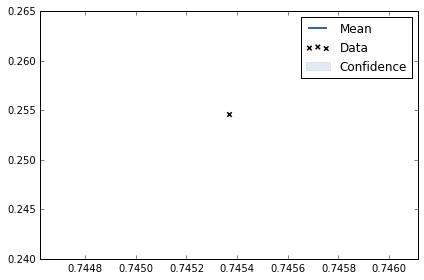

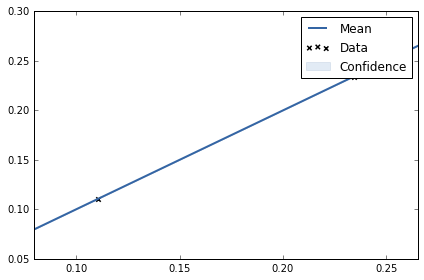

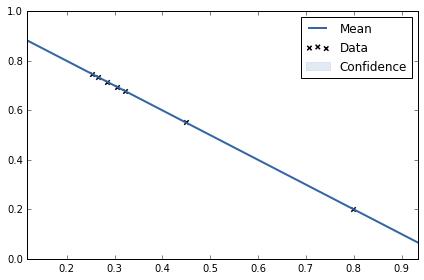

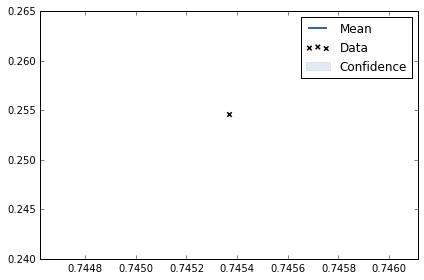

In [13]:
print [expert[0].state for expert in mix.experts]
mix.experts[0][0].gpr.plot()
mix.experts[1][0].gpr.plot()
mix.experts[2][0].gpr.plot()
mix.experts[3][0].gpr.plot()